In [1]:
from pathlib import Path

import numpy as np
import pypulseq as pp
from bmc.utils.seq.write import write_seq

import matplotlib.pyplot as plt

In [2]:
seqid = "90_90"
wdir = Path().resolve().parent
folder = wdir / "seq_lib"

In [3]:
# general settings
AUTHOR = "DANIEL MIKSCH"
FLAG_PLOT_SEQUENCE = True  # plot preparation block?
FLAG_CHECK_TIMING = True  # perform a timing check at the end of the sequence?
FLAG_POST_PREP_SPOIL = True  # add spoiler after preparation block?

# sequence definitions
defs: dict = {}
defs["a"] = 90 # a in degrees
defs["b0"] = 17  # B0 [T]

# defs["trec_m0"] = 12  # recovery time before M0 [s]
defs["m0_offset"] = 9  # m0 offset [ppm]
defs["offsets_ppm"] = np.array([defs["m0_offset"]])

defs["num_meas"] = defs["offsets_ppm"].size  # number of repetition

defs["seq_id_string"] = seqid  # unique seq id


seq_filename = defs["seq_id_string"] + ".seq"

In [4]:
sys = pp.Opts(
    max_grad=120000,
    grad_unit="mT/m",
    max_slew=1e9,
    slew_unit="T/m/s",
    rf_ringdown_time=0,
    rf_dead_time=0,
    rf_raster_time=1e-6,
    gamma=42576400,
    grad_raster_time=1e-6,
)

GAMMA_HZ = sys.gamma * 1e-6
defs["freq"] = defs["b0"] * GAMMA_HZ  # Larmor frequency [Hz]
GAMMA_HZ

42.5764

### RF events

In [5]:
flip_angle_90 = np.radians(defs['a'])
flip_angle_180 = np.radians(180)
t_pulse = 4e-3 

rf_90 = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_90_water = pp.make_gauss_pulse(
    flip_angle=flip_angle_90,
    system=sys,
    duration=t_pulse,         # Bandbreite in Hz
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

rf_180 = pp.make_gauss_pulse(
    flip_angle=flip_angle_180,
    system=sys,
    duration=t_pulse,
    center_pos=0.5,
    freq_offset=0,
    phase_offset=0,
    return_gz=False)

### Gradient events

In [6]:
spoil_amp = 0.9 * sys.max_grad  # Hz/m
rise_time = 0.05e-3 #(spoil_amp / GAMMA_HZ) / sys.max_slew  # spoiler rise time in seconds
spoil_dur = 1e-3  # complete spoiler duration in seconds
exchange_dur = 5e-3

In [7]:
def create_trapezoid(amplitude, duration, rise_time, dt=sys.grad_raster_time):
    if 2 * rise_time > duration:
        raise ValueError("Die Anstiegs- und Abfallzeit zusammen dürfen nicht länger als die Gesamtdauer sein.")

    # Anzahl der Samples für jede Phase
    num_rise_samples = int(rise_time / dt)  # Anzahl der Samples für die Anstiegsphase
    num_flat_samples = int((duration - 2 * rise_time) / dt)  # Anzahl der Samples für das Plateau
    total_samples = num_rise_samples * 2 + num_flat_samples  # Gesamte Anzahl der Samples

    # Trapezoid erstellen
    trapezoid = np.zeros(total_samples)

    # Anstiegsphase: Linear von 0 bis zur Amplitude
    rise = np.linspace(0, amplitude, num_rise_samples, endpoint=False)
    trapezoid[:num_rise_samples] = rise

    # Plateau: Konstante Amplitude
    trapezoid[num_rise_samples:num_rise_samples + num_flat_samples] = amplitude

    # Abfallphase: Linear von Amplitude zurück auf 0
    fall = np.linspace(amplitude, 0, num_rise_samples, endpoint=True)
    trapezoid[num_rise_samples + num_flat_samples:] = fall

    return trapezoid

In [8]:
trapeziod_spoil = create_trapezoid(spoil_amp, spoil_dur, rise_time)
trapeziod_exchange = create_trapezoid(spoil_amp, exchange_dur, rise_time)

gz_spoil = pp.make_arbitrary_grad(channel='z', 
                             system=sys, 
                             waveform=trapeziod_spoil,
                             )
gz_exchange = pp.make_arbitrary_grad(channel='z',
                                system=sys,
                                waveform=trapeziod_exchange,
                                )

len(np.unique(trapeziod_spoil))

99

In [9]:
# dt = sys.grad_raster_time  # Zeitauflösung

# trapezoid = create_trapezoid(spoil_amp, spoil_dur, rise_time, dt)

# # Plot
# import matplotlib.pyplot as plt
# time = np.arange(len(trapezoid)) * dt  # Zeitachse
# plt.plot(time, trapezoid)
# plt.title("Trapezoid with Slopes")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.show()
# spoil_amp

### Other events

In [10]:
delay_inter_etm = pp.make_delay(2e-3)
delay_exchange = pp.make_delay(2.5e-3)

pseudo_adc = pp.make_adc(num_samples=1, duration=1e-3)

### Sequence

In [11]:
seq = pp.Sequence()

offsets_hz = defs["offsets_ppm"] * defs["freq"]  # convert from ppm to Hz

In [12]:

rf_90.freq_offset = offsets_hz[0]
rf_180.freq_offset = offsets_hz[0]

seq.add_block(rf_90)
seq.add_block(gz_spoil)
seq.add_block(rf_90_water)

seq.add_block(pseudo_adc)

if FLAG_CHECK_TIMING:
    ok, error_report = seq.check_timing()
if ok:
    print("\nTiming check passed successfully")
else:
    print("\nTiming check failed! Error listing follows\n")
    print(error_report)


Timing check passed successfully


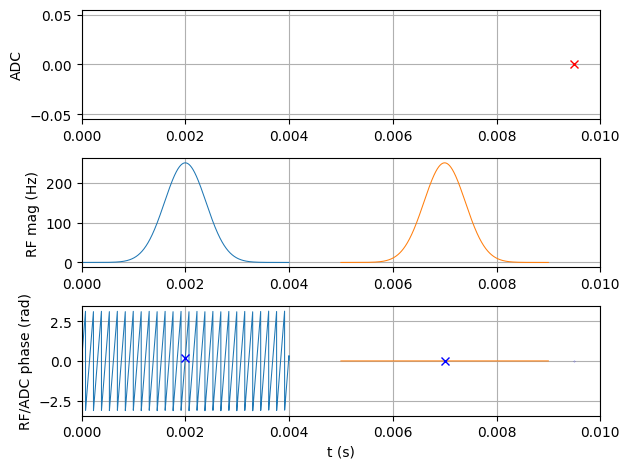

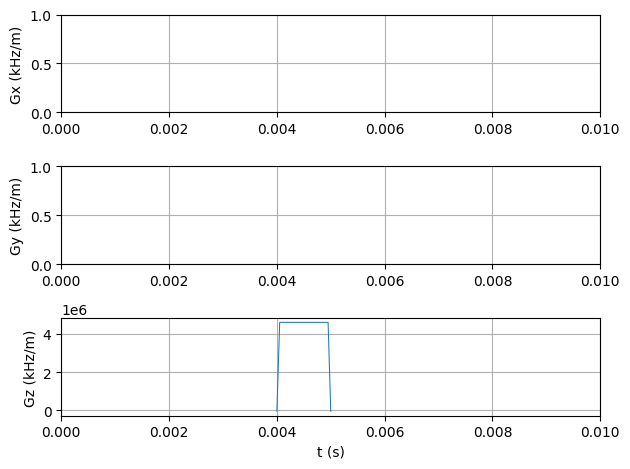

In [13]:
if FLAG_PLOT_SEQUENCE:
    seq.plot() #time_range=[0.00, .03]

In [14]:
write_seq(seq=seq, seq_defs=defs, filename=folder / seq_filename, author=AUTHOR, use_matlab_names=True)

In [15]:
pp.calc_rf_bandwidth(rf_90) / defs["freq"]

array([1.27107146])

In [16]:
# def print_sequence_overview():
#     """
#     Druckt eine Übersicht der wichtigsten Informationen der gegebenen MR-Sequenz.
#     :param sequence: Sequenz-Objekt
#     """
#     print("=" * 50)
#     print("SEQUENCE OVERVIEW")
#     print("=" * 50)

#     print(f"Sequence: {seqid}")
#     print(f"B0: {defs['b0']} T")

#     print("-" * 50)
#     print("RF-PULSE")
#     print("-" * 50)

#     # RF-Puls (falls verfügbar)

#     flip_angles = [defs["a"], 180]
#     for i, item in enumerate([rf_90, rf_180]):
#         print(f"RF{flip_angles[i]}")
#         print(f"Duration: {t_pulse:.5f} s")
#         print(f"Offset: {defs['offsets_ppm'][0]} ppm")
#         print(f"Flip angle: {flip_angles[i]}°")
#         print(f"Bandwidth: {(pp.calc_rf_bandwidth(item) / defs['freq'])[0]:.3f} ppm")

#     print("-" * 50)
#     print("GRADIENTS")
#     print("-" * 50)

#     # Gradientendetails (falls verfügbar)
#     gradients = [spoil_dur, rephase_dur]
#     for i, grad in enumerate([gz_spoil, gz_rephase]):
#         print(f"{i+1}. Gradient")
#         print(f"Duration: {gradients[i]:.5f} s")
#         print(f"Risetime: {rise_time:.5f} us")

#     print("=" * 50)

In [17]:
# print_sequence_overview()